In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error as mse
import math

In [2]:
# Loading data
data = pd.read_excel('SalesForecasting_TrainData(1).xlsx')
data.head()

,HQ,Country,State_of_outlet,City_of_outlet,Month,Day,Year,Total_Sales
0,Asia,India,NaN,Bombay (Mumbai),1,1,2005,72.2
1,Asia,India,NaN,Bombay (Mumbai),1,2,2005,72.7
2,Asia,India,NaN,Bombay (Mumbai),1,3,2005,74.3
3,Asia,India,NaN,Bombay (Mumbai),1,4,2005,78.9
4,Asia,India,NaN,Bombay (Mumbai),1,5,2005,81.5


In [3]:
print(data.shape)
data.info()

(17536, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HQ               17536 non-null  object 
 1   Country          17536 non-null  object 
 2   State_of_outlet  0 non-null      float64
 3   City_of_outlet   17536 non-null  object 
 4   Month            17536 non-null  int64  
 5   Day              17536 non-null  int64  
 6   Year             17536 non-null  int64  
 7   Total_Sales      17536 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,State_of_outlet,Month,Day,Year,Total_Sales
count,0.0,17536.000000,17536.000000,17536.000000,17536.000000
mean,NaN,6.524179,15.732892,2010.502053,80.117963
std,NaN,3.449400,8.801978,3.452525,13.315486
min,NaN,1.000000,1.000000,2005.000000,-99.000000
25%,NaN,4.000000,8.000000,2008.000000,77.500000
50%,NaN,7.000000,16.000000,2011.000000,82.600000
75%,NaN,10.000000,23.000000,2014.000000,86.100000
max,NaN,12.000000,31.000000,2016.000000,102.500000


 we have 17536 records, 7 features out of which 3 are
 categorical and 4 numerical. The target viable is continuous numeric.

 Exploratory Data analysis

In [5]:
# checking for null count
data.isnull().sum()/data.isnull().count()*100

HQ                   0.0
Country              0.0
State_of_outlet    100.0
City_of_outlet       0.0
Month                0.0
Day                  0.0
Year                 0.0
Total_Sales          0.0
dtype: float64

In [6]:

# checking for percent null count
data.isnull().sum()/data.isnull().count()*100


HQ                   0.0
Country              0.0
State_of_outlet    100.0
City_of_outlet       0.0
Month                0.0
Day                  0.0
Year                 0.0
Total_Sales          0.0
dtype: float64

 since State_of_outlet has 100% null values we drop that column

In [7]:
data.drop('State_of_outlet', axis=1, inplace=True)
data.head()


,HQ,Country,City_of_outlet,Month,Day,Year,Total_Sales
0,Asia,India,Bombay (Mumbai),1,1,2005,72.2
1,Asia,India,Bombay (Mumbai),1,2,2005,72.7
2,Asia,India,Bombay (Mumbai),1,3,2005,74.3
3,Asia,India,Bombay (Mumbai),1,4,2005,78.9
4,Asia,India,Bombay (Mumbai),1,5,2005,81.5


In [8]:
# checking for unique values
data.nunique()


HQ                  1
Country             1
City_of_outlet      4
Month              12
Day                31
Year               12
Total_Sales       539
dtype: int64

 Feature HQ and Country have only 1 unique value i.e the values are
 same throughout the entire column (100% singularity).
 Therefore we drop the entire HQ and Country column

In [9]:
data.drop(['HQ', 'Country'], axis=1, inplace=True)
data.head()

,City_of_outlet,Month,Day,Year,Total_Sales
0,Bombay (Mumbai),1,1,2005,72.2
1,Bombay (Mumbai),1,2,2005,72.7
2,Bombay (Mumbai),1,3,2005,74.3
3,Bombay (Mumbai),1,4,2005,78.9
4,Bombay (Mumbai),1,5,2005,81.5


 Feature Engineering

In [10]:
data['Date'] = data.Year.map(str)+'-'+data.Month.map(str)+'-'+data.Day.map(str)
data['Date']

0          2005-1-1
1          2005-1-2
2          2005-1-3
3          2005-1-4
4          2005-1-5
            ...    
17531    2016-12-27
17532    2016-12-28
17533    2016-12-29
17534    2016-12-30
17535    2016-12-31
Name: Date, Length: 17536, dtype: object

In [11]:
data['Date'] = pd.to_datetime(data.Date)
data['Date']

0       2005-01-01
1       2005-01-02
2       2005-01-03
3       2005-01-04
4       2005-01-05
           ...    
17531   2016-12-27
17532   2016-12-28
17533   2016-12-29
17534   2016-12-30
17535   2016-12-31
Name: Date, Length: 17536, dtype: datetime64[ns]

 dropping Year,Month and Day since we have Date column

In [12]:
data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
data.head()

,City_of_outlet,Total_Sales,Date
0,Bombay (Mumbai),72.2,2005-01-01
1,Bombay (Mumbai),72.7,2005-01-02
2,Bombay (Mumbai),74.3,2005-01-03
3,Bombay (Mumbai),78.9,2005-01-04
4,Bombay (Mumbai),81.5,2005-01-05


In [13]:
# checking time frame
min(data.Date), max(data.Date)

(Timestamp('2005-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

 We have data from 2005 to 2016.

In [14]:
# Converting this Date timeframe  into index.
data.set_index('Date', inplace=True)
data.head()


,City_of_outlet,Total_Sales
Date,,
2005-01-01,Bombay (Mumbai),72.2
2005-01-02,Bombay (Mumbai),72.7
2005-01-03,Bombay (Mumbai),74.3
2005-01-04,Bombay (Mumbai),78.9
2005-01-05,Bombay (Mumbai),81.5


<AxesSubplot:xlabel='Date', ylabel='Total_Sales'>

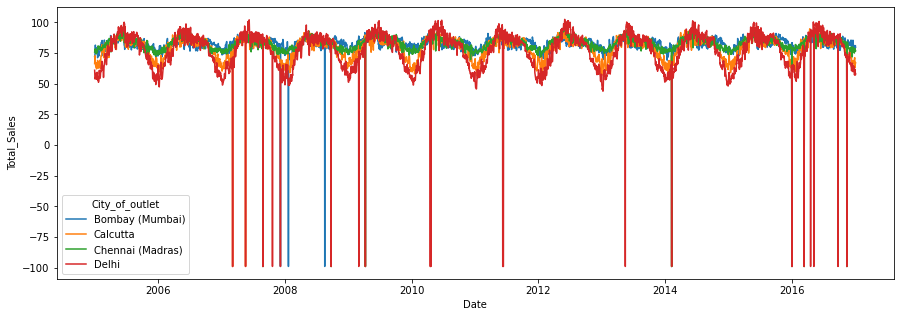

In [15]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, y=data['Total_Sales'],
             x=data.index, hue='City_of_outlet',)


 we see that there are some outliers and they do not seem to be valid

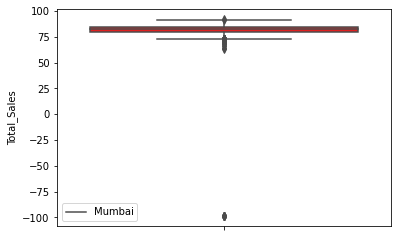

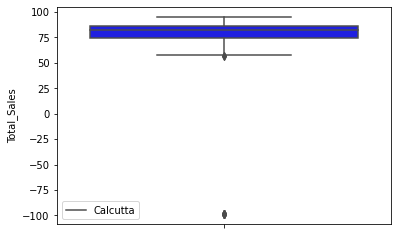

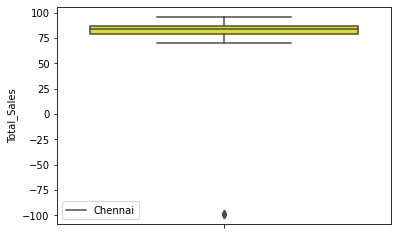

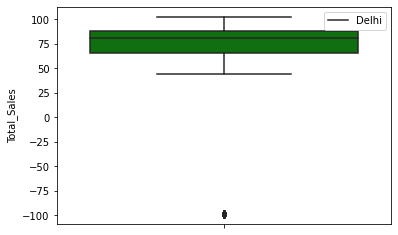

In [16]:
sns.boxplot(data=data[data.City_of_outlet ==
            'Bombay (Mumbai)'], y='Total_Sales', color='red')
plt.legend(['Mumbai'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet == 'Calcutta'],
            y='Total_Sales', color='blue',)
plt.legend(['Calcutta'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet ==
            'Chennai (Madras)'], y='Total_Sales', color='yellow',)
plt.legend(['Chennai'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet == 'Delhi'],
            y='Total_Sales', color='green',)
plt.legend(['Delhi'])
plt.show()


 For box plot and lineplot we see that the outliers seem to be
 some negative values. Therefore we drop negative values to drop outliers

In [17]:
data = data[data['Total_Sales'] > 0]

<AxesSubplot:xlabel='Date', ylabel='Total_Sales'>

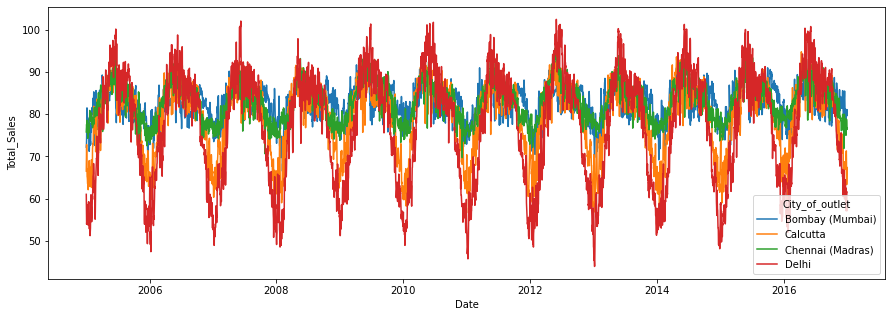

In [18]:
# plotting figure again
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, y=data['Total_Sales'],
             x=data.index, hue='City_of_outlet',)


In [19]:
# Data counts in each city
print('Mumbai:', len(data[data.City_of_outlet == 'Bombay (Mumbai)']))
print('Calcutta:', len(data[data.City_of_outlet == 'Calcutta']))
print('Chennai:', len(data[data.City_of_outlet == 'Chennai (Madras)']))
print('Delhi:', len(data[data.City_of_outlet == 'Delhi']))


Mumbai: 4373
Calcutta: 4373
Chennai: 4376
Delhi: 4357


In [20]:
# creating a dictionary for each city
dic_data = {'Mumbai': data[data.City_of_outlet == 'Bombay (Mumbai)'],
            'Calcutta': data[data.City_of_outlet == 'Calcutta'],
            'Chennai': data[data.City_of_outlet == 'Chennai (Madras)'],
            'Delhi': data[data.City_of_outlet == 'Delhi']
            }
dic_data['Mumbai']

,City_of_outlet,Total_Sales
Date,,
2005-01-01,Bombay (Mumbai),72.2
2005-01-02,Bombay (Mumbai),72.7
2005-01-03,Bombay (Mumbai),74.3
2005-01-04,Bombay (Mumbai),78.9
2005-01-05,Bombay (Mumbai),81.5
...,...,...
2016-12-27,Bombay (Mumbai),79.8
2016-12-28,Bombay (Mumbai),79.9
2016-12-29,Bombay (Mumbai),80.6


In [21]:
# dropping City_of_outlet column since the key value of dictionary specifies it
for city in dic_data.keys():
    dic_data[city].drop('City_of_outlet',axis=1,inplace=True)

# printing sample city
dic_data['Mumbai']

C:\Users\varma\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Total_Sales
Date,
2005-01-01,72.2
2005-01-02,72.7
2005-01-03,74.3
2005-01-04,78.9
2005-01-05,81.5
...,...
2016-12-27,79.8
2016-12-28,79.9
2016-12-29,80.6


In [22]:
# now performing time series lstm analysis for each city
# now splitting the data into train and validation set
dic_train={}
dic_val={}

for city in dic_data.keys():
    train_len=int(len(dic_data[city])*0.66)
    val_len=len(dic_data[city])-train_len
    dic_train[city]=dic_data[city].iloc[:train_len]
    dic_val[city]=dic_data[city].iloc[train_len:train_len+val_len]

# printing sample train and validation data
print(dic_train['Calcutta'].tail())
dic_val['Calcutta'].head()


            Total_Sales
Date                   
2012-11-27         69.4
2012-11-28         67.7
2012-11-29         67.9
2012-11-30         68.4
2012-12-01         69.4


,Total_Sales
Date,
2012-12-02,68.4
2012-12-03,68.2
2012-12-04,69.3
2012-12-05,71.3
2012-12-06,68.6


In [23]:
# Now normalizing the data
# dic_sc={}
# dic_train_sc={}
# dic_val_sc={}
# for city in dic_train.keys():
#     dic_train_sc[city]=dic_train[city]
#     dic_val_sc[city]=dic_val[city]
#     dic_sc[city]=MinMaxScaler(feature_range=(0,1))
#     dic_train_sc[city]['Total_Sales']=dic_sc[city].fit_transform(dic_train[city])
#     dic_val_sc[city]['Total_Sales']=dic_sc[city].transform(dic_val[city])

# dic_train_sc[city].head()


In [24]:

dic_sc={}
dic_train_sc={}
dic_val_sc={}
for city in dic_train.keys():
    dic_sc[city]=MinMaxScaler(feature_range=(0,1))
    dic_train_sc[city]=dic_sc[city].fit_transform(dic_train[city])
    dic_val_sc[city]=dic_sc[city].transform(dic_val[city])



In [25]:
seq_size = length =  10 # selecting past 10 day records
batch_size = 1 # for 1st iteration lets consider 1
n_features=1 # since we have only 1 feature 
dic_train_generator={}
dic_val_generator={}
for city in dic_train_sc.keys():
    dic_train_generator[city]=TimeseriesGenerator(dic_train_sc[city],dic_train_sc[city],
    length=length,batch_size=1)
    dic_val_generator[city]=TimeseriesGenerator(dic_val_sc[city],dic_val_sc[city],
    length=length,batch_size=1)


In [26]:
print('Samples in train data: %d' % len(dic_train_sc[city]))
print('Samples in train generator: %d' % len(dic_train_generator[city]))


Samples in train data: 2875
Samples in train generator: 2865


  We see that samples in train generator is 10 less than Samples in train data
 since we hace taken seq_size of 10 days

In [27]:

dic_model={}
for city in dic_train_sc.keys():
    # creating model
    dic_model[city]=Sequential()
    dic_model[city].add(LSTM(units=64,activation='relu',input_shape=(seq_size,n_features),
        return_sequences=True))
    dic_model[city].add(LSTM(units=32,activation='relu',input_shape=(seq_size,n_features),
        return_sequences=False))
    dic_model[city].add(Dense(1)) # since output is 1
        
    # compiling model
    dic_model[city].compile(optimizer='adam', loss='mean_squared_error')

# printing sample model summary
dic_model['Delhi'].summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [28]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
model.add(Dense(1))

In [29]:
# running all models
for city in dic_train_sc.keys():
    dic_model[city].fit_generator(generator=dic_train_generator[city],
     epochs=10, validation_data=dic_val_generator[city])

    

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
2876/2876 [==============================] - 14s 5ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 2/10
2876/2876 [==============================] - 13s 5ms/step - loss: 0.0044 - val_loss: 0.0068
Epoch 3/10
2876/2876 [==============================] - 13s 5ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 4/10
2876/2876 [==============================] - 13s 5ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/10
2876/2876 [==============================] - 13s 5ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/10
2876/2876 [==============================] - 13s 5ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 7/10
2876/2876 [==============================] - 13s 4ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 8/10
2876/2876 [==============================] - 13s 5ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/10
2876/2876 [==============================] - 13s 4ms/step - loss: 0.0033 - val_loss: 0.00

In [30]:
# predicting on train and validation data
dic_train_p={}
dic_val_p={}
for city in dic_train_sc.keys():
    dic_train_p[city]=dic_model[city].predict(dic_train_generator[city])
    dic_val_p[city]=dic_model[city].predict(dic_val_generator[city])

In [31]:
# getting actual values from scaled values
dic_train_p_inv={}
dic_val_p_inv={}

for city in dic_train_sc.keys():
    dic_train_p_inv[city] = dic_sc[city].inverse_transform(dic_train_p[city])
    # trainY_inverse = scaler.inverse_transform(train)
    dic_val_p_inv[city] = dic_sc[city].inverse_transform(dic_val_p[city])
    # testY_inverse = scaler.inverse_transform(test)


In [32]:
# calculate root mean squared error
dic_train_score={}
dic_val_score={}
for city in dic_train_sc.keys():
    dic_train_score[city] = math.sqrt(mse(dic_train_p_inv[city][:], dic_train[city].iloc[length:,0]))
    print('Train Score for %s : %.2f RMSE' % (city,dic_train_score[city]))

    dic_val_score[city] = math.sqrt(mse(dic_val_p_inv[city][:], dic_val[city].iloc[length:,0]))
    print('Validation Score for %s : %.2f RMSE' % (city,dic_val_score[city]))


Train Score for Mumbai : 1.83 RMSE
Validation Score for Mumbai : 1.81 RMSE
Train Score for Calcutta : 2.13 RMSE
Validation Score for Calcutta : 2.06 RMSE
Train Score for Chennai : 1.53 RMSE
Validation Score for Chennai : 1.50 RMSE
Train Score for Delhi : 2.68 RMSE
Validation Score for Delhi : 2.72 RMSE


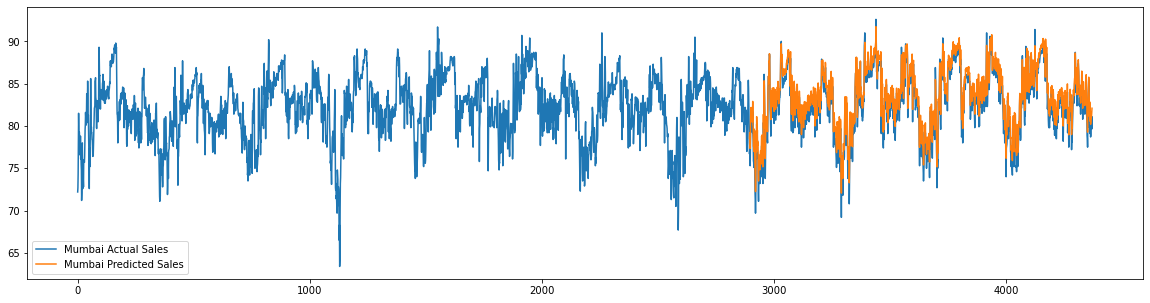

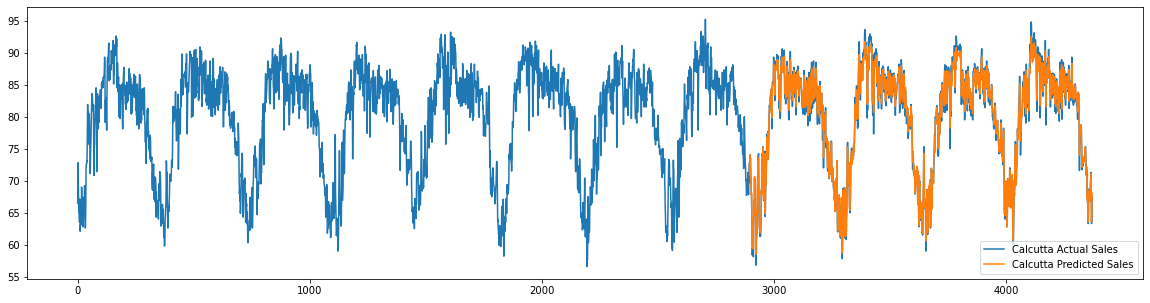

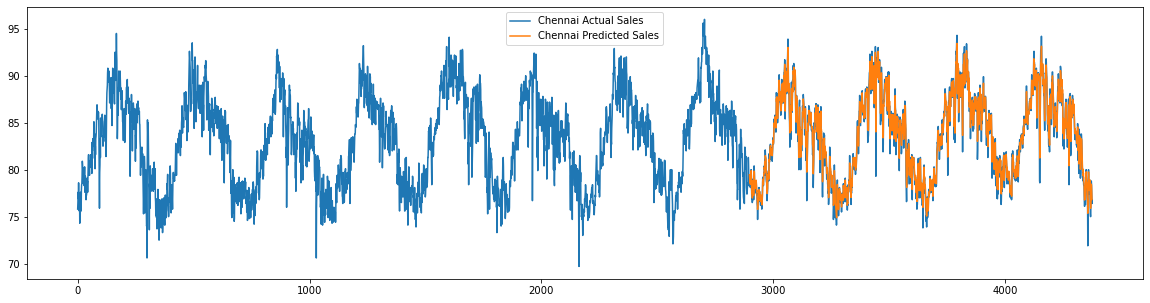

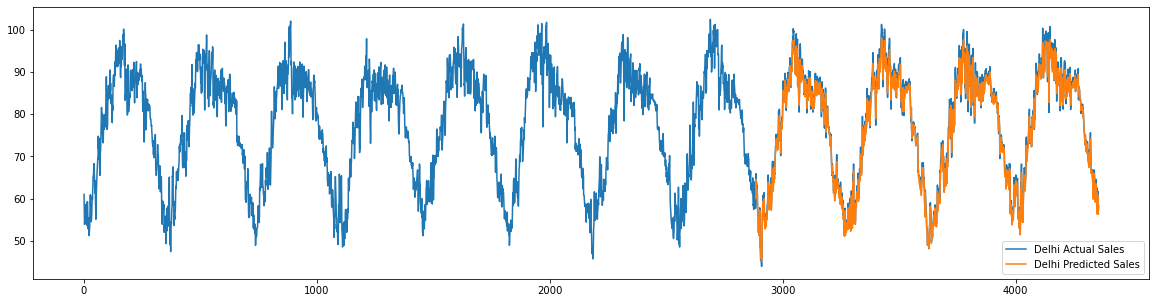

In [33]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
dic_train_pre_plot={}
dic_val_pre_plot={}

for city in dic_train_sc.keys():
    dic_train_pre_plot[city] = np.empty_like(dic_data[city])
    dic_train_pre_plot[city][:, :] = np.nan
    dic_train_pre_plot[city][length:len(dic_train_p_inv[city])+length, :] = dic_train_p_inv[city][:]

    # shift test predictions for plotting
    dic_val_pre_plot[city] = np.empty_like(dic_data[city])
    dic_val_pre_plot[city][:, :] = np.nan
    #testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
    dic_val_pre_plot[city][len(dic_train[city])+(length)-1:len(dic_data[city])-1, :] = dic_val_p_inv[city][:]

    plt.figure(figsize=(20,5))
    # plot baseline and predictions
    # plt.plot(scaler.inverse_transform(dataset))
    # plt.plot(dic_train_pre_plot[city],label=city+' Predicted training Sales')
    plt.plot(dic_data[city].values,label=city+' Actual Sales')
    plt.plot(dic_val_pre_plot[city],label=city+' Predicted Sales')
    
    plt.legend()
    # plt.xticks(list(dic_data[city].index))
    plt.show()


# %%
# forecasting sales
test_predictions={}


In [100]:
# forecasting sales
test_1_predictions={}
n_input=10
n_features=1
dic_test_generator={}
for city in dic_train_sc.keys():
    #Select last n_input values from the train data
    first_test_batch = dic_val_sc[city][-n_input-1:]
    #reshape the data into LSTM required (#batch,#timesteps,#features)
    # current_batch = first_test_batch.reshape((1, n_input, n_features))
    test_1_predictions[city]=[]
    dic_test_generator[city]=TimeseriesGenerator(first_test_batch,first_test_batch,
    length=length,batch_size=1)
    for i in range(365*2):  # for next 2 years
    # get prediction, grab the exact number using the [0]
        pred = dic_model[city].predict(dic_test_generator[city])[0]
        # Add this prediction to the list
        test_1_predictions[city].append(pred)

        first_test_batch = np.append(first_test_batch[1:,:],[pred],axis=0)
        dic_test_generator[city]=TimeseriesGenerator(first_test_batch,first_test_batch,
        length=length,batch_size=1)



In [101]:
# applying inverse transform on predicted values
actual_predictions={}

for city in dic_train_sc.keys():
    # actual_predictions[city]=[]
    actual_predictions[city]=dic_sc[city].inverse_transform(test_1_predictions[city])


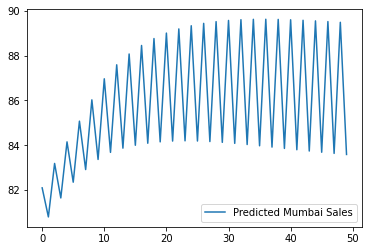

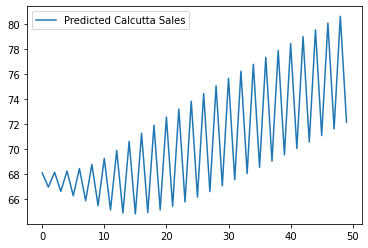

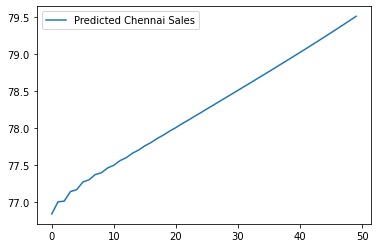

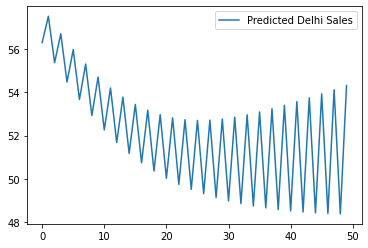

In [102]:
# printing first 50 actual predictions
for city in dic_train_sc.keys():
    plt.plot(actual_predictions[city][:50],label='Predicted '+ city+ ' Sales')
    plt.legend()
    plt.show()